# Attention Rollout by Jacobgil  

[Website](https://jacobgil.github.io/deeplearning/vision-transformer-explainability)  
[GitHub](https://github.com/jacobgil/vit-explain/tree/main?tab=readme-ov-file)

In [1]:
from functools import partial
from netrc import netrc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

## Dataloader

In [2]:
classes = ['Halite','Quartz','Dolomite','Calcite','Gibbsite','Hematite']
path = 'Databases/Classification/'
class Diffractogramme(Dataset):
    def __init__(self, train = True):
        """
            train (boolean) : train(True) or test(False) set
        """
        self.train = train
        if self.train:
            self.datalist = pd.read_csv(path+'labels_train_6classes.csv', sep=',',header=None,names=['fichier','train','label']) 
        else :
            self.datalist = pd.read_csv(path+'labels_test_6classes.csv', sep=',',header=None,names=['fichier','train','label'])


    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        file_name = self.datalist['fichier'][idx] #Get file name
        file = pd.read_csv(path+file_name,header=None,skiprows=1,names=['Intensity']) # Read file with pandas
        diffracto = file['Intensity'] # Signal
        label = self.datalist['label'][idx]  #label
        l = classes.index(label)
        diffracto = torch.tensor(diffracto).float() #Convert
        sample = [diffracto,l]
        return sample
    
batch_size = 64
train_data = Diffractogramme(train = True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = Diffractogramme(train = False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## ViT Block

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(EncoderBlock, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        self.drop_path = DropPath(
            drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        at, q,k,v = self.attn(self.norm1(x))
        x = x + self.drop_path(at)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        list_q.append(q)
        list_k.append(k)
        list_v.append(v)
        return x

class Attention(nn.Module):

    def __init__(self,
                 dim,  
                 num_heads=2,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape  
        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # make torchscript happy (cannot use tensor as tuple)
        q, k, v = qkv[0], qkv[1], qkv[2]
        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x,q, k, v
    
    
    
class Mlp(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def Spectra_Embedding(x, spec_length, embed_dim):
    batch_size = x.shape[0]
    new_spec_length = (spec_length // embed_dim) * embed_dim
    x = x[:, :new_spec_length]
    x = torch.reshape(x, (batch_size, spec_length // embed_dim, embed_dim))
    return x

class VIT(nn.Module):
    def __init__(self, spec_length=2000, num_output=1,
                 embed_dim=40, depth=12, num_heads=2, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., norm_layer=None,
                 act_layer=None):
        
        # MSTransformer
        super(VIT, self).__init__()
        self.num_classes = num_output
        self.spec_length = spec_length
        self.num_features = self.embed_dim = embed_dim
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU
        #self.pos_embed = PositionalEncoding(embed_dim,dropout = 0.1)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, (spec_length//embed_dim) + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)
        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]
        self.blocks = nn.Sequential(*[
            EncoderBlock(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                        norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

        self.head = nn.Linear(embed_dim, num_output)

    def forward(self, x):
        # [B , xrd_length] --> [B , xrd_length/embed_dim , embed_dim]
        x = Spectra_Embedding(x, self.spec_length, self.embed_dim)
        #print(x.shape)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        #print(x.shape)
        #x = self.pos_embed(x)
        x = self.blocks(x)
        x = self.norm(x)
        x = self.head(x)

        return x[:, 0]
    
def _init_vit_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)

def VIT_model(spec_length=2905,num_output: int = 1):
    model = VIT(spec_length=spec_length,
                              embed_dim=80,
                              depth=12,
                              num_heads=2,
                              num_output=num_output)
    return model

In [4]:
num_classes=6
model = VIT_model(spec_length=2905,num_output=num_classes)
model.load_state_dict(torch.load('Trained_model/Classif'))
model.eval()

list_q = []
list_k = []
list_v = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        #outputs = torch.exp(outputs)/torch.sum(torch.exp(outputs))
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted,labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 600 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 600 test images: 99 %


## Attention Rollout

#### Formula attention rollout

$$ AttentionRollout_L=(A_L+I)AttentionRollout_{L−1} $$



### Attention Rollout by classes

In [5]:
Matrix_A = np.zeros(shape = (100,36))
Matrix_plot_A = np.zeros(shape = (6,36))


classes_list_nb = [0,100,200,300,400,500]
c = 0
for k_classes in classes_list_nb:
    for i in range(100):
        X, l = test_data[k_classes+i]
        list_q = []
        list_k = []
        list_v = []
        model.eval()
        with torch.no_grad():
            X_tensor = torch.unsqueeze(X,0)
            y = model(X_tensor)
            p = torch.argmax(y)

        A = torch.zeros(size = (len(list_q),2,37,37))
        for i in range(len(list_q)):
            Q = list_q[i]
            K = list_k[i]
            V = list_v[i]
            attn = (Q @ K.transpose(-2, -1))
            A[i,:] = attn

        # Min Attention fused
        attention_head_fused = A.min(axis = 1)[0]

        # Identity matrix initialisation
        I = torch.eye(n = 37)

        A_L = torch.zeros(size = (12,37,37))
        for i in range(12):
            A_L[i] = (attention_head_fused[i,:,:] + I)/2 
            A_L[i] = A_L[i] / A_L[i].sum(dim = -1)


        A_R = torch.zeros(size = (12,37,37))
        A_R[0] = A_L[0]
        for i in range(11):
            A_R[i+1] = torch.matmul(A_R[i],A_L[i+1])

        Attn = A_R[11,0,1:]
        max_value = torch.max(Attn)
        min_value = torch.min(Attn)
        normalized_Attn = (Attn - min_value) / (max_value - min_value)
        normalized_Attn = np.array(normalized_Attn.detach())




        Matrix_A[i,:] = normalized_Attn

    M_A = np.mean(Matrix_A, axis = 0)
    M_A = (M_A - np.min(M_A)) / (np.max(M_A) - np.min(M_A))
    Matrix_plot_A[c,:] = M_A
    c += 1

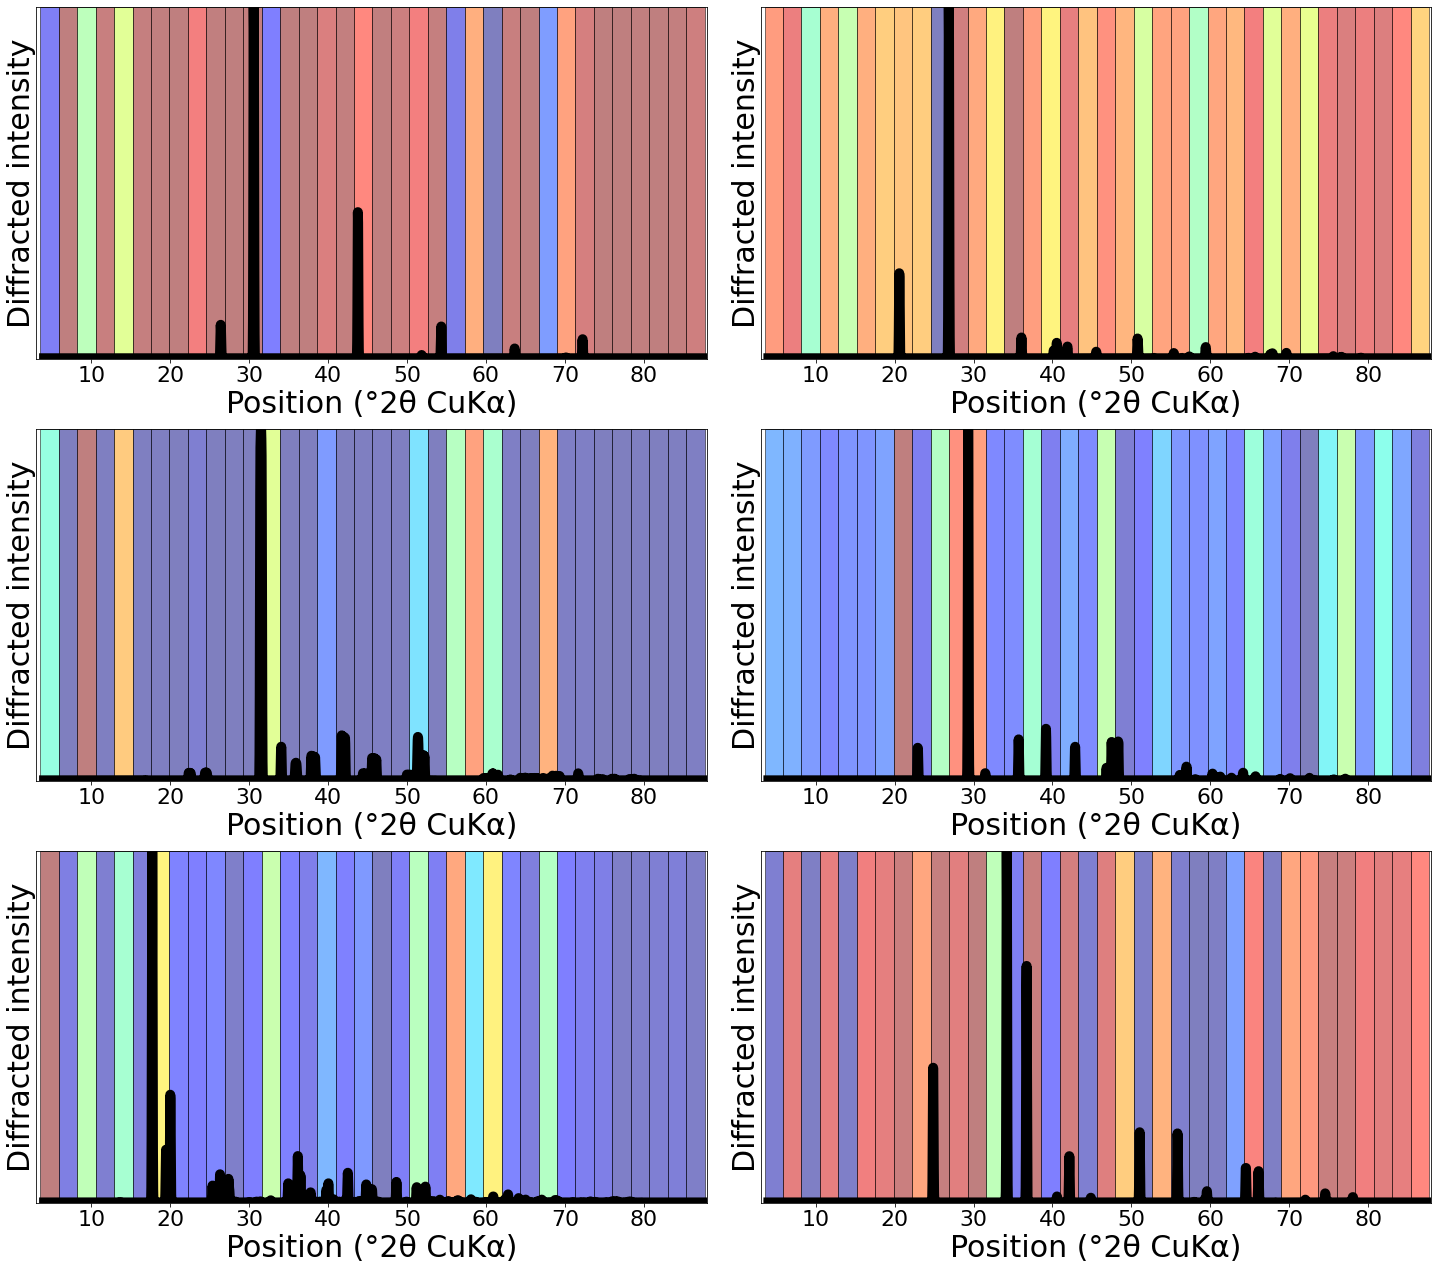

In [6]:
theta_min = 4.0001
theta_max = 90.020055
inc_theta = 0.029611
th = np.arange(theta_min,theta_max,inc_theta)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(25, 22))
colors = ['#FFD700', '#50C878', '#4169E1', '#E0115F', '#8A2BE2']  
X, l = test_data[0]

x_barplot = np.arange(start = 4, stop = len(normalized_Attn)+4)*2.3392690000000043
barplot = ax1.bar(x_barplot-2*2.3392690000000043, [1] * len(normalized_Attn),width= 2.3392690000000043, color=plt.cm.jet(Matrix_plot_A[0,:]), edgecolor='black', alpha = 0.5)
ax1.plot(th, X.detach(), linewidth = 10, color = 'black')
ax1.set_xlabel('Position (°2θ CuKα)', fontsize = 30)
ax1.set_ylabel('Diffracted intensity', fontsize = 30, labelpad=0)
ax1.tick_params(axis = 'both', labelsize = 22)
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
ax1.set_xlim(3, 88)
ax1.set_ylim(-0.001, 1.001)


X, l = test_data[100]
x_barplot = np.arange(start = 4, stop = len(normalized_Attn)+4)*2.3392690000000043
barplot = ax2.bar(x_barplot-2*2.3392690000000043, [1] * len(normalized_Attn),width= 2.3392690000000043, color=plt.cm.jet(Matrix_plot_A[1,:]), edgecolor='black', alpha = 0.5)
ax2.plot(th, X.detach(), linewidth = 10, color = 'black')
ax2.set_xlabel('Position (°2θ CuKα)', fontsize = 30)
ax2.set_ylabel('Diffracted intensity', fontsize = 30, labelpad=0)
ax2.tick_params(axis = 'both', labelsize = 22)
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
ax2.set_xlim(3, 88)
ax2.set_ylim(-0.001, 1.001)


X, l = test_data[200]
x_barplot = np.arange(start = 4, stop = len(normalized_Attn)+4)*2.3392690000000043
barplot = ax3.bar(x_barplot-2*2.3392690000000043, [1] * len(normalized_Attn),width= 2.3392690000000043, color=plt.cm.jet(Matrix_plot_A[2,:]), edgecolor='black', alpha = 0.5)
ax3.plot(th, X.detach(), linewidth = 10, color = 'black')
ax3.set_xlabel('Position (°2θ CuKα)', fontsize = 30)
ax3.set_ylabel('Diffracted intensity', fontsize = 30, labelpad=0)
ax3.tick_params(axis = 'both', labelsize = 22)
ax3.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
ax3.set_xlim(3, 88)
ax3.set_ylim(-0.001, 1.001)


X, l = test_data[300]
x_barplot = np.arange(start = 4, stop = len(normalized_Attn)+4)*2.3392690000000043
barplot = ax4.bar(x_barplot-2*2.3392690000000043, [1] * len(normalized_Attn),width= 2.3392690000000043, color=plt.cm.jet(Matrix_plot_A[3,:]), edgecolor='black', alpha = 0.5)
ax4.plot(th, X.detach(), linewidth = 10, color = 'black')
ax4.set_xlabel('Position (°2θ CuKα)', fontsize = 30)
ax4.set_ylabel('Diffracted intensity', fontsize = 30, labelpad=0)
ax4.tick_params(axis = 'both', labelsize = 22)
ax4.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
ax4.set_xlim(3, 88)
ax4.set_ylim(-0.001, 1.001)

X, l = test_data[400]
x_barplot = np.arange(start = 4, stop = len(normalized_Attn)+4)*2.3392690000000043
barplot = ax5.bar(x_barplot-2*2.3392690000000043, [1] * len(normalized_Attn),width= 2.3392690000000043, color=plt.cm.jet(Matrix_plot_A[4,:]), edgecolor='black', alpha = 0.5)
ax5.plot(th, X.detach(), linewidth = 10, color = 'black')
ax5.set_xlabel('Position (°2θ CuKα)', fontsize = 30)
ax5.set_ylabel('Diffracted intensity', fontsize = 30, labelpad=0)
ax5.tick_params(axis = 'both', labelsize = 22)
ax5.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
ax5.set_xlim(3, 88)
ax5.set_ylim(-0.001, 1.001)


X, l = test_data[500]
x_barplot = np.arange(start = 4, stop = len(normalized_Attn)+4)*2.3392690000000043
barplot = ax6.bar(x_barplot-2*2.3392690000000043, [1] * len(normalized_Attn),width= 2.3392690000000043, color=plt.cm.jet(Matrix_plot_A[5,:]), edgecolor='black', alpha = 0.5)
ax6.plot(th, X.detach(), linewidth = 10, color = 'black')
ax6.set_xlabel('Position (°2θ CuKα)', fontsize = 30)
ax6.set_ylabel('Diffracted intensity', fontsize = 30, labelpad=0)
ax6.tick_params(axis = 'both', labelsize = 22)
ax6.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
ax6.set_xlim(3, 88)
ax6.set_ylim(-0.001, 1.001)



plt.subplots_adjust(hspace=0.2,wspace = 0.08)

plt.show()


## Positional embedding with cosine similarity

In [7]:
pos = model.pos_embed
pos = pos.detach()
pos_embeddings = np.array(pos)
pos_embeddings = pos_embeddings[0,:,:]
cosine_sim = cosine_similarity(pos_embeddings)

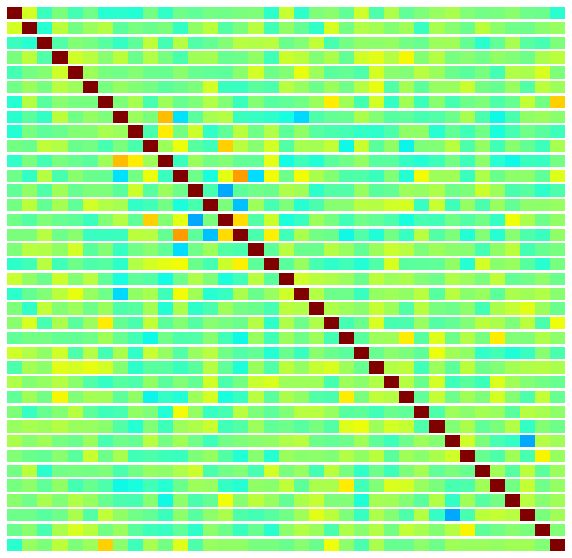

In [8]:
fig, axs = plt.subplots(nrows=cosine_sim.shape[0], figsize=(10, 10))
for i, ax in enumerate(axs):
    sns.heatmap(cosine_sim[i:i+1], cmap="jet", annot=False, cbar=False, vmin=-1, vmax=1, ax=ax)
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_ylabel('')  
plt.show()
